# Sparkify - Predicting User Churn

Sparkify is a fictional music streaming service similar to Spotify, with a free-tier supported by advertisements and a monthly subscription service. Predicting user churn enables Sparkify to identify users who are considering cancelling their membership and offer special discounts or services to retain these users and maximize profit.

This code will use event log data about user interactions to create features that could be predictive of which users will churn, and then train and evaluate models for this classification task.

## 1. PySpark Setup

In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, desc, when, dense_rank, countDistinct
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import max as Fmax, min as Fmin, sum as Fsum, mean as Fmean, first as Ffirst, col as Fcol

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [2]:
#Set up spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn Prediction") \
    .getOrCreate()

## 2. Load and Clean Dataset

In [3]:
#Read event data from medium file
path = "data/medium-sparkify-event-data.json"
sparkify_event_log = spark.read.json(path)

sparkify_event_log.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
#View first row of the data
sparkify_event_log.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

In [5]:
#Count number of rows
sparkify_event_log.count()

543705

In [6]:
#Check for any rows with a missing sessionId - these would likely be a data error within the Sparkify system
sparkify_event_log.filter(sparkify_event_log['sessionId'] == '').count()
#There are no rows which are missing a sessionId so no cleaning need to address these

0

In [7]:
#Check for any rows with a missing userId - these won't be useful to predict user churn
sparkify_event_log.filter(sparkify_event_log['userId'] == "").count()

15700

In [8]:
#Investigate which pages were visited by users without a UserId
sparkify_event_log.filter(sparkify_event_log['userId'] == "").select(sparkify_event_log['page']).distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



There are many rows without a userId. Looking at the events these relate to, they relate to Sparkify information pages such as Home, About and Help. It makes sense that these pages would be accessed by logged out or guest users so we can drop them from this dataset as they won't be useful for predicting churn.

In [9]:
user_event_log = sparkify_event_log.filter(sparkify_event_log['userId'] != "")
user_event_log.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

In [10]:
# Check for any other columns with null values
null_counts = {col:user_event_log.filter(user_event_log[col].isNull()).count() for col in user_event_log.columns}
null_counts 
#The only remaining null values are for artist, song, and length 
#these correspond to rows where the event is not listening to song, which seems sensible

{'artist': 95128,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 95128,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 95128,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

In [11]:
#Drop columns that won't be useful to reduce memory requirements
user_event_log = user_event_log.drop('firstName','lastName','userAgent','artist','song')
user_event_log.head(5)

[Row(auth='Logged In', gender='M', itemInSession=20, length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, status=200, ts=1538352011000, userId='293'),
 Row(auth='Logged In', gender='M', itemInSession=74, length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, status=200, ts=1538352025000, userId='98'),
 Row(auth='Logged In', gender='M', itemInSession=184, length=202.37016, level='paid', location='Orlando-Kissimmee-Sanford, FL', method='PUT', page='NextSong', registration=1535953455000, sessionId=178, status=200, ts=1538352118000, userId='179'),
 Row(auth='Logged In', gender='M', itemInSession=185, length=None, level='paid', location='Orlando-Kissimmee-Sanford, FL', method='PUT', page='Logout', registration=1535953455000, sessionId=178, status=307, ts=1538352119000, userId='179'),
 Row(auth='Logged In', gend

In [12]:
#Check for duplicate rows
print('Duplicate rows: ', user_event_log.count() - user_event_log.distinct().count())

Duplicate rows:  0


## 3. Exploratory Data Analysis

In [13]:
#Count number of unique users
print('Unique users:', user_event_log.select("userId").dropDuplicates().count())

Unique users: 448


In [14]:
#Investigate page column
page_counts = user_event_log.groupby(user_event_log.page).count().orderBy('count', ascending=False)
page_counts.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|432877|
|           Thumbs Up| 23826|
|                Home| 19089|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|         Roll Advert|  7773|
|              Logout|  5990|
|         Thumbs Down|  4911|
|           Downgrade|  3811|
|            Settings|  2964|
|                Help|  2644|
|               About|  1026|
|             Upgrade|   968|
|       Save Settings|   585|
|               Error|   503|
|      Submit Upgrade|   287|
|    Submit Downgrade|   117|
|              Cancel|    99|
|Cancellation Conf...|    99|
+--------------------+------+



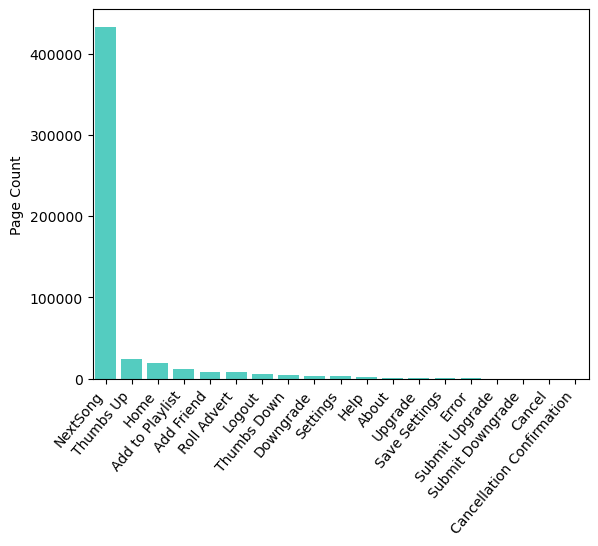

In [15]:
page_plot = sns.barplot(x='page', y='count', data=page_counts.toPandas(), color='turquoise')
page_plot.set_xlabel(None)
page_plot.set_ylabel("Page Count",fontsize=10)
plt.tick_params(labelsize=10)
plt.xticks(rotation=50, ha='right');

From this we can see that the majority of events correspond to playing songs, which makes sense for a music streaming service. Some of the other common events such as Thumbs Up, Add to Playlist or Roll Advert could be used to create predictive features.
The other key event here is the Cancel Confirmation page, which will be used to define user churn.

In [16]:
#Look at the range of values in other categorical columns
cat_cols = ['auth', 'gender', 'level', 'method', 'status']
for col in cat_cols:
    user_event_log.groupBy(col).count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    99|
|Logged In|527906|
+---------+------+

+------+------+
|gender| count|
+------+------+
|     F|225393|
|     M|302612|
+------+------+

+-----+------+
|level| count|
+-----+------+
| free|109961|
| paid|418044|
+-----+------+

+------+------+
|method| count|
+------+------+
|   PUT|489128|
|   GET| 38877|
+------+------+

+------+------+
|status| count|
+------+------+
|   307| 43902|
|   404|   503|
|   200|483600|
+------+------+



### Create user churn flag

In [17]:
#Create CHURN event flag using user-defined function
create_churn_event_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_event_log = user_event_log.withColumn("Churn_Event", create_churn_event_flag("page"))

user_event_log.head()

Row(auth='Logged In', gender='M', itemInSession=20, length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, status=200, ts=1538352011000, userId='293', Churn_Event=0)

In [18]:
user_event_log.groupBy('Churn_Event').count().show()

+-----------+------+
|Churn_Event| count|
+-----------+------+
|          1|    99|
|          0|527906|
+-----------+------+



There were only 99 cancellation events out of the 500k rows - fortunately for Sparkify it looks like cancellation is a pretty rare event. Since we're interested in predicting which users will churn, we next need to flag all rows belonging to a churn user. We can do this by using a Window function to find the maximum value of the Churn_Event flag for each user and attach this to all their other log entries.

In [19]:
#create a window based on userId and sorted by event timestamp
user_window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [20]:
user_event_log = user_event_log.withColumn("Churn_User", Fmax("Churn_Event").over(user_window))

In [21]:
#Check first few rows for a user known to have churned - now have Churn_User set for all of that user's rows
user_event_log.filter(user_event_log.userId == '18').head(3)

[Row(auth='Cancelled', gender='M', itemInSession=69, length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=4671, status=200, ts=1543522398000, userId='18', Churn_Event=1, Churn_User=1),
 Row(auth='Logged In', gender='M', itemInSession=68, length=None, level='paid', location='Kansas City, MO-KS', method='PUT', page='Cancel', registration=1535623466000, sessionId=4671, status=307, ts=1543522388000, userId='18', Churn_Event=0, Churn_User=1),
 Row(auth='Logged In', gender='M', itemInSession=67, length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Downgrade', registration=1535623466000, sessionId=4671, status=200, ts=1543522387000, userId='18', Churn_Event=0, Churn_User=1)]

In [22]:
user_event_log.groupBy('Churn_User').count().show()
user_event_log.select('userId','Churn_User').distinct().groupBy('Churn_User').count().show()

+----------+------+
|Churn_User| count|
+----------+------+
|         1|103646|
|         0|424359|
+----------+------+

+----------+-----+
|Churn_User|count|
+----------+-----+
|         1|   99|
|         0|  349|
+----------+-----+



From this we can see that nearly a quarter of the users in our dataset have churned, which would not be good for Sparkify's profits! We clearly need to find a way to identify these users before they churn and find strategies to prevent this. We can start by looking at the relationship between our Churn users and other users based on some of the other features in the event log.

In [23]:
#Select the latest row for each user 
#If they have churned this will be the cancellation page, otherwise whatever the user's last activity was
#There are a small number of users with two entries with identical timestamps, so added itemInSession to the ordering
#to ensure only 1 record is selected per user
user_time_window = Window.partitionBy('userId').orderBy(desc('ts'), desc('itemInSession'))

user_event_log = user_event_log.withColumn('Rank',dense_rank().over(user_time_window))

users_df = user_event_log.filter(user_event_log.Rank == 1).toPandas()
users_df.head(5)

,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,status,ts,userId,Churn_Event,Churn_User,Rank
0,Cancelled,F,67,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,Cancellation Confirmation,1538016340000,166,200,1539254318000,100010,1,1,1
1,Cancelled,M,138,NaN,paid,"Chicago-Naperville-Elgin, IL-IN-WI",GET,Cancellation Confirmation,1536269906000,239,200,1540877026000,200002,1,1,1
2,Cancelled,F,20,NaN,paid,"Allentown-Bethlehem-Easton, PA-NJ",GET,Cancellation Confirmation,1536885688000,1228,200,1539187234000,296,1,1,1
3,Logged In,M,7,NaN,free,"Corpus Christi, TX",PUT,Add to Playlist,1533157139000,2220,200,1542265610000,125,0,0,1
4,Cancelled,F,44,NaN,paid,"Vineland-Bridgeton, NJ",GET,Cancellation Confirmation,1532224335000,3475,200,1541948983000,124,1,1,1


In [24]:
#Count number of sessions per user
user_session_count = user_event_log.groupBy('userId').agg(countDistinct('sessionId').alias('session_count'))

#join churn_user flag on for visualisation
user_session_count_df = user_session_count.join(user_event_log.select('userId','Churn_User').distinct(),'userId','outer') \
                                          .toPandas()

user_session_count_df.head()

,userId,session_count,Churn_User
0,100010,2,1
1,200002,5,1
2,296,5,1
3,125,3,0
4,124,17,1


In [25]:
def plot_churn_counts(df, col):
    '''Plot countplot for specified column, split by churn status'''
    if col == 'Churn_User':
        plt = sns.countplot(x=col, data=df);
        plt.set_xlabel('User Churned', fontsize=15)
    else:
        plt = sns.countplot(x=col, data=df, hue='Churn_User');
        plt.set_xlabel(col.capitalize(), fontsize=15)
    plt.set_ylabel("Count of users", fontsize=15)
    plt.tick_params(labelsize=10)

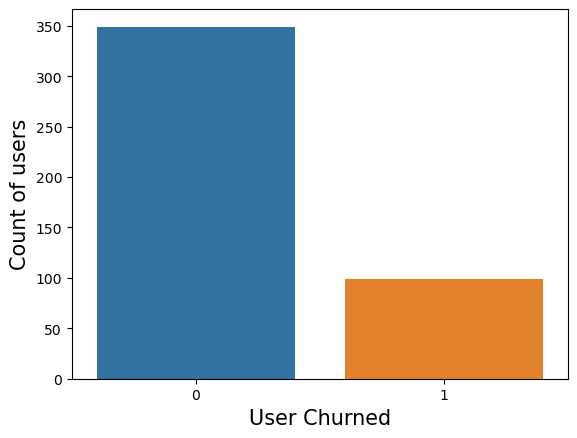

In [26]:
plot_churn_counts(users_df,'Churn_User')

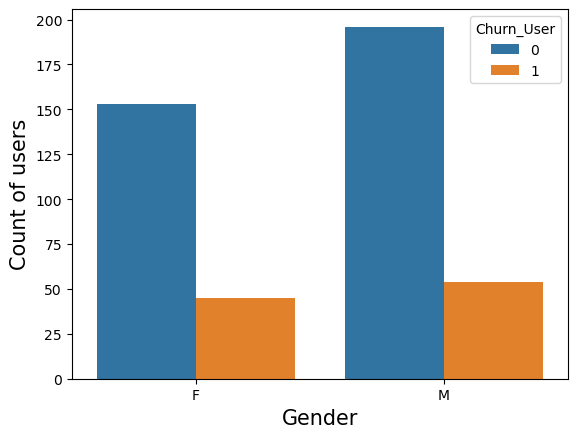

In [27]:
plot_churn_counts(users_df,'gender')

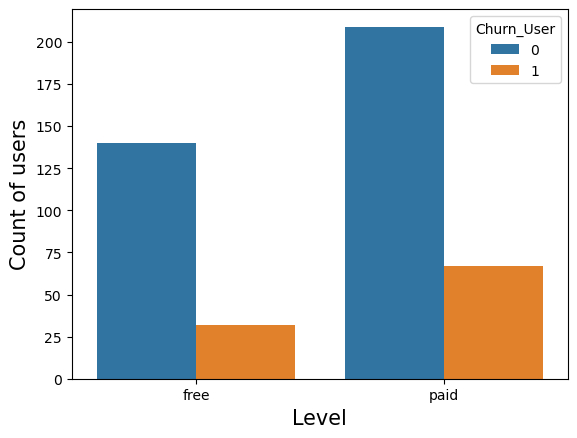

In [28]:
plot_churn_counts(users_df,'level')

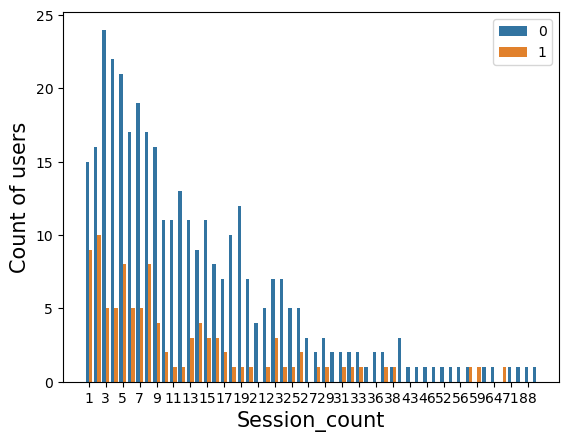

In [29]:
plot_churn_counts(user_session_count_df,'session_count')
plt.locator_params(axis='x', nbins=30)
plt.legend(loc="upper right");

From these visualizations we can see that there are more male than female users and that they have a similar churn rate. The churn rate is also higher for paid users than free users, as free users can simply stop using the service without cancelling. New or infrequent users, with less than 15 sessions in our data period are much more likely to churn than users with a high number of sessions, which seems sensible - happier users will be much more likely to return to the service.

## 4. Feature Engineering

Spark machine learning models require the input features to be in numeric form, so we'll focus on creating numeric rather than categorical factors. There are some categorical factors in the input data that can be easily converted to a binary numeric representation, so we will also consider these factors.

In [30]:
#Convert gender to binary categorical feature
user_event_log = user_event_log.withColumn("gender", when(user_event_log.gender == "M",0) \
                  .when(user_event_log.gender == "F",1))

user_event_log.head()

Row(auth='Cancelled', gender=1, itemInSession=67, length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='GET', page='Cancellation Confirmation', registration=1538016340000, sessionId=166, status=200, ts=1539254318000, userId='100010', Churn_Event=1, Churn_User=1, Rank=1)

The event log captures the user's subscription level (paid/free) at each page. Since we're looking to construct a user-level modelling dataset to predict which users will churn, it would be more useful to have a flag that indicates their most recent level and whether they have ever previously been in the paid tier.

In [31]:
#Map level to binary indicator
user_event_log = user_event_log.withColumn("level", when(user_event_log.level == "free",0) \
      .when(user_event_log.level == "paid",1))

In [32]:
#For each user, identify their most recent level in the event log using the Window function already used to identify churn
#Also create a flag to identify users who have ever been in the paid tier
user_current_level = user_event_log.select('userId',
                                           Ffirst('level',True).over(user_window).alias('current_level'),
                                           Fmax('level').over(user_window).alias('ever_paid')) \
                                    .distinct()

In [33]:
#create page-view counts per user, using the same approach as we used to create our churn flag
#ignore uninteresting pages such as About or Home
#Also ignore NextSong and Roll Advert as these will be heavily linked to session length so will be considered separately
page_dict = {'friend': 'Add Friend', 'thumbs_up': 'Thumbs Up', 'thumbs_down': 'Thumbs Down',
             'upgrade': 'Submit Upgrade', 'downgrade': 'Submit Downgrade','error': 'Error', 
             'playlist': 'Add to Playlist'
}
for key in page_dict.keys():
    udf_page = udf(lambda x: 1 if x == page_dict[key] else 0, IntegerType())
    user_event_log = user_event_log.withColumn('p_' + key, udf_page("page"))

#Check each page type has been set correctly
user_event_log.select('page',user_event_log.colRegex("`(p_)+?.+`")).distinct().show()


+--------------------+--------+-----------+-------------+---------+-----------+-------+----------+
|                page|p_friend|p_thumbs_up|p_thumbs_down|p_upgrade|p_downgrade|p_error|p_playlist|
+--------------------+--------+-----------+-------------+---------+-----------+-------+----------+
|     Add to Playlist|       0|          0|            0|        0|          0|      0|         1|
|                Help|       0|          0|            0|        0|          0|      0|         0|
|Cancellation Conf...|       0|          0|            0|        0|          0|      0|         0|
|         Roll Advert|       0|          0|            0|        0|          0|      0|         0|
|    Submit Downgrade|       0|          0|            0|        0|          1|      0|         0|
|         Thumbs Down|       0|          0|            1|        0|          0|      0|         0|
|            Settings|       0|          0|            0|        0|          0|      0|         0|
|         

In [34]:
#Create count variables for each of these page views
#partition the dataframe based on the userId column
user_window = Window.partitionBy("userId")
#return the sum of values for each page type
for key in page_dict:
    user_event_log = user_event_log.withColumn('sum_' + key, Fsum('p_' + key).over(user_window))

#Check first few rows for unique users
user_page_counts = user_event_log.select('userId',user_event_log.colRegex("`(sum_)+?.+`")).distinct()
user_page_counts.show()

+------+----------+-------------+---------------+-----------+-------------+---------+------------+
|userId|sum_friend|sum_thumbs_up|sum_thumbs_down|sum_upgrade|sum_downgrade|sum_error|sum_playlist|
+------+----------+-------------+---------------+-----------+-------------+---------+------------+
|100010|         3|            4|              3|          0|            0|        0|           1|
|200002|         2|           15|              5|          1|            0|        0|           6|
|   296|         2|            8|              0|          1|            0|        0|           3|
|   125|         3|            3|              1|          0|            0|        0|           2|
|   124|        26|          102|             15|          0|            0|        0|          45|
|    51|         3|           16|              1|          0|            0|        2|           8|
|     7|        16|           12|              4|          0|            0|        0|           6|
|200037|  

Create session-aggregated features such as average length of session per user

In [35]:
flag_song = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
flag_advert = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())

user_event_log = user_event_log.withColumn("song", flag_song("page"))
user_event_log = user_event_log.withColumn("advert", flag_advert("page"))

In [36]:
session_window = Window.partitionBy(["userId", "sessionId"]).orderBy(desc("ts")) \
                    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
session_timings = user_event_log.select('userId',
                                        'sessionId',
                                        Fsum('song').over(session_window).alias('session_song_count'),
                                        Fsum('advert').over(session_window).alias('session_advert_count'),
                                        Fmax('ts').over(session_window).alias('session_end'),
                                        Fmin('ts').over(session_window).alias('session_start')).distinct()
session_timings = session_timings.withColumn('session_duration_seconds', (session_timings['session_end'] - session_timings['session_start'])/1000)
session_timings.show(5)

+------+---------+------------------+--------------------+-------------+-------------+------------------------+
|userId|sessionId|session_song_count|session_advert_count|  session_end|session_start|session_duration_seconds|
+------+---------+------------------+--------------------+-------------+-------------+------------------------+
|100002|      293|                73|                   1|1541146660000|1541126654000|                 20006.0|
|100025|      287|                80|                   1|1541178742000|1541157564000|                 21178.0|
|100028|       28|                18|                   6|1538375989000|1538371925000|                  4064.0|
|   148|     2290|                51|                   6|1540928387000|1540916022000|                 12365.0|
|   157|     3145|               250|                   0|1541481617000|1541421220000|                 60397.0|
+------+---------+------------------+--------------------+-------------+-------------+------------------

In [37]:
avg_session_duration = session_timings.groupBy('userId') \
                                      .agg(Fmean('session_song_count').alias('avg_session_songs'),
                                           Fmean('session_duration_seconds').alias('avg_session_duration_seconds'),
                                           Fmean('session_advert_count').alias('avg_session_adverts')) \
                                      .orderBy(session_timings.userId.cast('Int'))
avg_session_duration = avg_session_duration.withColumn('ratio_advert_song', (Fcol("avg_session_adverts") / Fcol("avg_session_songs")))
avg_session_duration.show(5)

+------+-----------------+----------------------------+-------------------+--------------------+
|userId|avg_session_songs|avg_session_duration_seconds|avg_session_adverts|   ratio_advert_song|
+------+-----------------+----------------------------+-------------------+--------------------+
|     2|70.81818181818181|          17160.272727272728|                0.0|                 0.0|
|     3|             24.0|                      6254.0|                1.0|0.041666666666666664|
|     4|          26.3125|                     6075.25|               2.25|  0.0855106888361045|
|     5|            54.75|                     13246.5|               4.75|  0.0867579908675799|
|     6|59.31578947368421|          14649.052631578947| 2.4210526315789473| 0.04081632653061224|
+------+-----------------+----------------------------+-------------------+--------------------+
only showing top 5 rows



In [38]:
#Join together all of the newly engineered features to create a modelling dataset
users = user_event_log.select('userId','Churn_User','gender').distinct()
df = users.join(user_current_level,'userId','outer') \
          .join(user_session_count,'userId','outer') \
          .join(avg_session_duration,'userId','outer') \
          .join(user_page_counts,'userId','outer')

#Rename Churn_User to label for setting up an ML pipeline
df = df.withColumnRenamed('Churn_User', 'label')

In [39]:
df.head()

Row(userId='100010', label=1, gender=1, current_level=0, ever_paid=0, session_count=2, avg_session_songs=48.0, avg_session_duration_seconds=12622.5, avg_session_adverts=11.0, ratio_advert_song=0.22916666666666666, sum_friend=3, sum_thumbs_up=4, sum_thumbs_down=3, sum_upgrade=0, sum_downgrade=0, sum_error=0, sum_playlist=1)

In [40]:
#Check that we still have 448 rows (one for each unique userId)
df.count()

448

## 5. Modelling

In [41]:
#Split data into train and test
train, test = df.randomSplit([0.7, 0.3], seed=42)

In [42]:
train.groupBy('label').count().show()
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   72|
|    0|  247|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    1|   27|
|    0|  102|
+-----+-----+



In [43]:
#Create list of features for modelling - everything in df except userId and label
feature_columns = list(set(df.columns) - set(['userId','label']))

In [44]:
#Set up components for modelling pipeline:

#Pyspark requires all input features to be contained in a numeric vector 
assembler = VectorAssembler(inputCols=feature_columns, outputCol='feature_col_vect')

#Scale numeric values using StandardScaler to avoid features with a larger range having too much influence
#e.g. avg_session_duration_seconds has values in the 10s of thousands, some other features have a maximum of 1
scaler = StandardScaler(inputCol="feature_col_vect", outputCol="features")

#Set up evaluator to calculate F1 score
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [45]:
def fit_score_cv_pipeline(crossval, train_df, test_df):
    '''Fit Pyspark Crossvalidation pipeline and score on train and test datasets'''
    t_start = pd.Timestamp.now()
    print(f'Beginning to fit pipeline {t_start}')
    cv_model = crossval.fit(train_df)
    t_fit_end = pd.Timestamp.now()
    print(f'fit time: {(t_fit_end - t_start).total_seconds()} seconds')
    print(f'best params: {cv_model.getEstimatorParamMaps()[np.argmax(cv_model.avgMetrics)]}')
    train_preds = cv_model.transform(train_df)
    test_preds = cv_model.transform(test_df)
    print(f'Cross validation Avg F1 score: {cv_model.avgMetrics[np.argmax(cv_model.avgMetrics)]}')
    print(f'test F1 score: {f1_evaluator.evaluate(test_preds)}')
    print(f'test Accuracy: {round(test_preds.filter(test_preds.label == test_preds.prediction).count()/ test_preds.count()*100)}%')
    t_score_end = pd.Timestamp.now()
    print(f'score time: {(t_score_end - t_fit_end).total_seconds()} seconds')
    
    #plot cross validate score to check tuning has resulted in differences in model performance
    plt.scatter(np.arange(len(cv_model.avgMetrics)),cv_model.avgMetrics)
    plt.xlabel('Tuning iteration')
    plt.ylabel('Avg cross validation F1 score');
    return cv_model

### Logistic Regression

In [46]:
#Initialize logistic regression model and pipeline
lr =  LogisticRegression(maxIter=50)
pipeline = Pipeline(stages=[assembler, scaler, lr])

#Define hyperparameter search space for tuning
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0, 0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam,[0, 0.01, 0.1]) \
    .build()

#Set up 3-fold cross validation
lr_cv = CrossValidator(estimator=pipeline,
                       estimatorParamMaps=lr_paramGrid,
                       evaluator=f1_evaluator,
                       numFolds=3)


Beginning to fit pipeline 2022-10-12 09:50:51.751074
fit time: 2683.391967 seconds
best params: {Param(parent='LogisticRegression_4b8d94390a92', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_4b8d94390a92', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}
Cross validation Avg F1 score: 0.7673154329763257
test F1 score: 0.7374816677142257
test Accuracy: 78%
score time: 108.478518 seconds


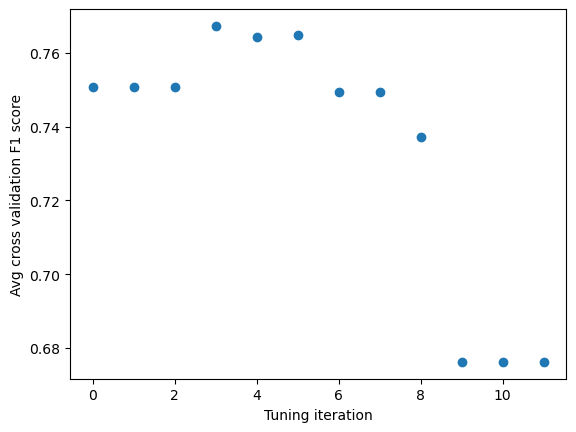

In [47]:
lr_model = fit_score_cv_pipeline(lr_cv,train,test)

### Linear SVM

In [48]:
#Initialize linear support vector pipeline
svm = LinearSVC(maxIter=50)
pipeline = Pipeline(stages=[assembler, scaler, svm])

#Define hyperparameter search space for tuning
svm_paramGrid = ParamGridBuilder() \
        .addGrid(svm.regParam,[ 0, 0.01, 0.1]) \
        .build()

#Set up 3-fold cross validation
svm_cv = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=svm_paramGrid,
                        evaluator=f1_evaluator,
                        numFolds=3)


Beginning to fit pipeline 2022-10-12 10:37:23.832781
fit time: 1536.444315 seconds
best params: {Param(parent='LinearSVC_04196bbbf274', name='regParam', doc='regularization parameter (>= 0).'): 0.0}
Cross validation Avg F1 score: 0.7309829030876551
test F1 score: 0.6905656545140653
test Accuracy: 78%
score time: 90.48088 seconds


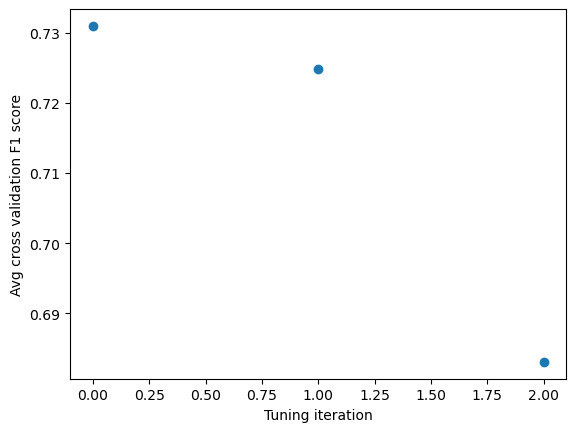

In [49]:
svm_model = fit_score_cv_pipeline(svm_cv,train,test)

### Decision Tree

In [51]:
#Initialize decision tree pipeline
dtc = DecisionTreeClassifier(seed=6582595169495365855)
pipeline = Pipeline(stages=[assembler, scaler, dtc])

#Define hyperparameter search space for tuning
dt_paramGrid = ParamGridBuilder() \
        .addGrid(dtc.maxDepth,[2,4,6,8]) \
        .addGrid(dtc.impurity,['entropy','gini']) \
        .build()

#Set up 3-fold cross validation
dt_cv = CrossValidator(estimator=pipeline,
                       estimatorParamMaps=dt_paramGrid,
                       evaluator=f1_evaluator,
                       numFolds=3)


Beginning to fit pipeline 2022-10-12 11:06:40.802670
fit time: 521.079334 seconds
best params: {Param(parent='DecisionTreeClassifier_1e88919e6c1f', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='DecisionTreeClassifier_1e88919e6c1f', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini'}
Cross validation Avg F1 score: 0.7304657638493536
test F1 score: 0.6767877000435141
test Accuracy: 73%
score time: 88.314508 seconds


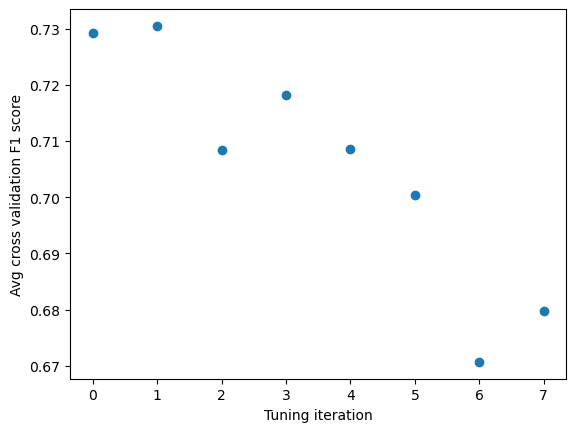

In [52]:
dt_model = fit_score_cv_pipeline(dt_cv,train,test)

### Random Forest

In [53]:
#Initialize decision tree pipeline
rfc = RandomForestClassifier(seed = 6582595169495365855)
pipeline = Pipeline(stages=[assembler, scaler, rfc])

#Define hyperparameter search space for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rfc.maxDepth, [3, 4, 5, 6]) \
    .addGrid(rfc.numTrees, [10, 20, 50]) \
    .build()

#Set up 3-fold cross validation
crossval_rf = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=f1_evaluator,
                              numFolds=3)


Beginning to fit pipeline 2022-10-12 11:16:50.382782
fit time: 922.378604 seconds
best params: {Param(parent='RandomForestClassifier_de5e2f41b9d6', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3, Param(parent='RandomForestClassifier_de5e2f41b9d6', name='numTrees', doc='Number of trees to train (>= 1).'): 20}
Cross validation Avg F1 score: 0.7528218153414495
test F1 score: 0.6905656545140653
test Accuracy: 78%
score time: 92.420062 seconds


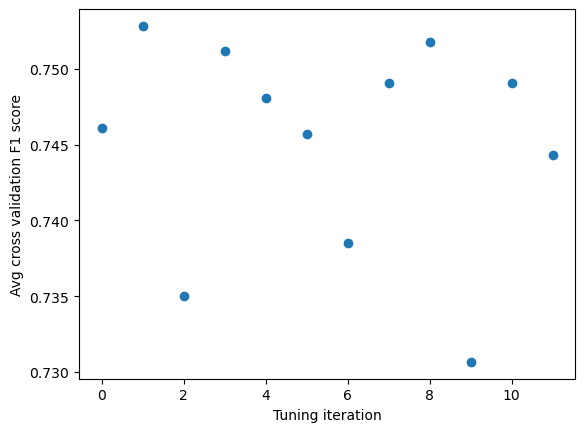

In [54]:
rf_model = fit_score_cv_pipeline(crossval_rf,train,test)

In [57]:
#The best F1 score came from the logistic regression model, so we'll use this to calculate final predictions
test_user_predictions = lr_model.transform(test).toPandas()

pd.crosstab(test_user_predictions['prediction'],test_user_predictions['label'])

label,0,1
prediction,,
0.0,97,23
1.0,5,4


### Conclusions

This project evaluated 4 different types of classification model for a binary prediction of user churn. These models all achieved a similar level of accuracy on the test data, but in our key metric of F1 score the clear winner was a logistic regression model using no regularization (tuning showed the optimal hyperparameters to be regParam = 0 and elasticNetParam = 0).


The final predictions show the impact of having an imbalanced data set - the model achieved an accuracy of 78% but only correctly identified 4 Churn users out of 27. Further work to refine the models and adjust the prediction threshold would be useful. One option could be to return a churn probability instead of a binary label, and then Sparkify could target a fixed proportion of the users with the highest likelihood of cancellation.
